In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal

# local imports
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Load `.mat` files containing response times and corresponding noise stimulus

In [3]:
data_path = "/mnt/Data/prerna_noise/aki_data/"
resp_timing = loadmat(os.path.join(data_path, "resp_timing.mat"))
stim = loadmat(os.path.join(data_path, "stim.mat"))["stim"]

### Extract relevant information from loaded `resp_timing` and `stim` data structures

In [4]:
resp_times = np.squeeze(resp_timing["resp_timing"])

matlab_idxs, noise_xaxis, noise = stim.T
matlab_idxs = np.squeeze([i[0] for i in matlab_idxs])
noise = np.stack([frame for frame in noise], axis=0).astype(np.float)
# noise[:, 5, 10] = np.sin(np.arange(noise.shape[0]) * 0.1)

n_frames = len(noise_xaxis)
noise_dt = np.squeeze(noise_xaxis[1])
noise_freq = 1 / noise_dt

print("noise movie shape:", noise.shape)
print(
    "%i frames of noise (%.2f seconds), presented at an interval of %.4fs (%.2fHz)" 
    % (n_frames, n_frames * noise_dt, noise_dt, noise_freq)
)
print("number of responses:", len(resp_times))

noise movie shape: (3200, 20, 20)
3200 frames of noise (266.67 seconds), presented at an interval of 0.0833s (12.00Hz)
number of responses: 90


/tmp/ipykernel_4372/3568568797.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noise = np.stack([frame for frame in noise], axis=0).astype(np.float)


<IPython.core.display.Javascript object>


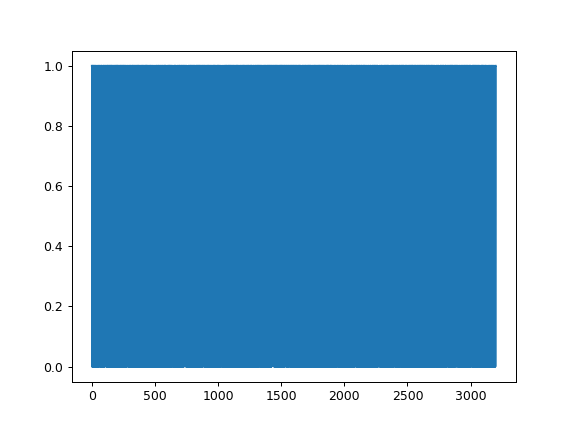

In [5]:
f, a = plt.subplots(1)
# a.plot(np.sin(np.arange(noise.shape[0]) * 0.1))
a.plot(noise[:, 5, 10])

<IPython.core.display.Javascript object>


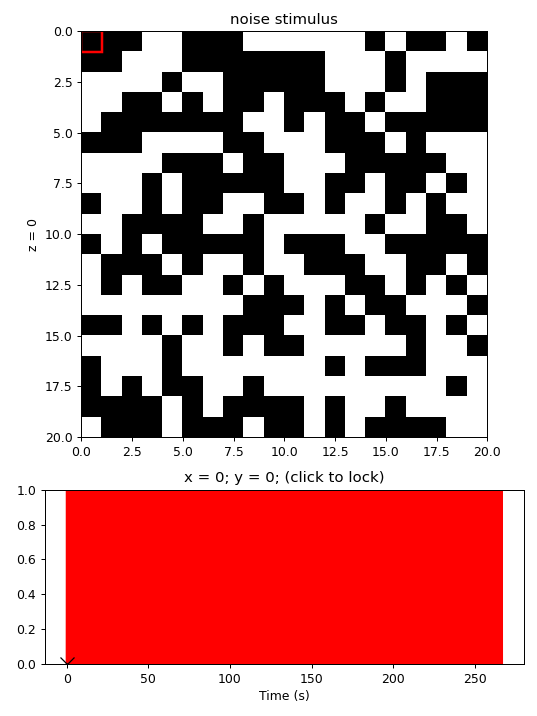

In [6]:
noise_plot = StackExplorer(    
    noise,
    zaxis=noise_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    cmap="gray",
    figsize=(6, 8)
)
noise_plot.stack_ax.set_title("noise stimulus")
noise_plot.beam_ax.set_xlabel("Time (s)")
noise_plot.fig.tight_layout()

### Example df signal and extracted peak times

Compare the times located in `pks` to those obtained with scipy `signal.find_peaks`.

In [7]:
df_xaxis, df = loadmat(os.path.join(data_path, "df2.mat"))["df2"].T
pks = np.squeeze(loadmat(os.path.join(data_path, "pks.mat"))["pks"])

df_dt = df_xaxis[1] - df_xaxis[0]  # time step

<IPython.core.display.Javascript object>


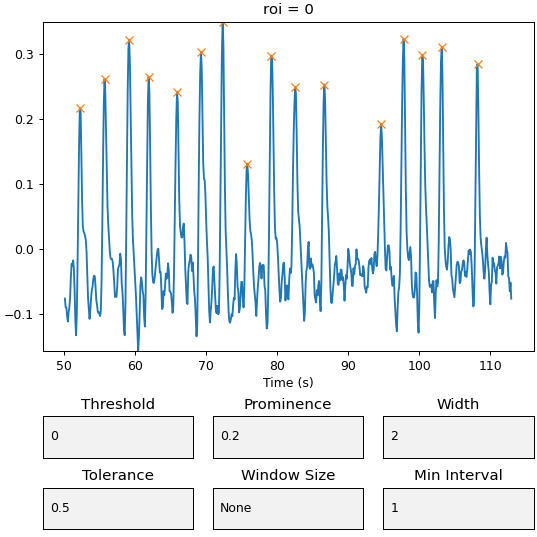

In [8]:
peak_explorer = PeakExplorer(
    df_xaxis, 
    df.reshape(1, -1),
    prominence=.2,
    width=2,
    tolerance=.5,
    distance=1
)

### Generate event triggered averages
Specify `lead_time` and `post_time` to control the amount of time cut from the stimulus before and after the events in `resp_times`.

In [9]:
lead_time = 2.0  # seconds before event
post_time = 1.0  # seconds after event

window_time = lead_time + post_time
stop_time = np.max(noise_xaxis) - post_time
window_frames = nearest_index(noise_xaxis, np.min(noise_xaxis) + window_time)
window_xaxis = np.arange(window_frames) * noise_dt - lead_time
window_stack = np.mean(
    [
        lead_window(noise_xaxis, noise, t + post_time, window_frames)
        for t in resp_times if t > lead_time and ((t + post_time) < stop_time)
    ],
    axis=0
)

<IPython.core.display.Javascript object>


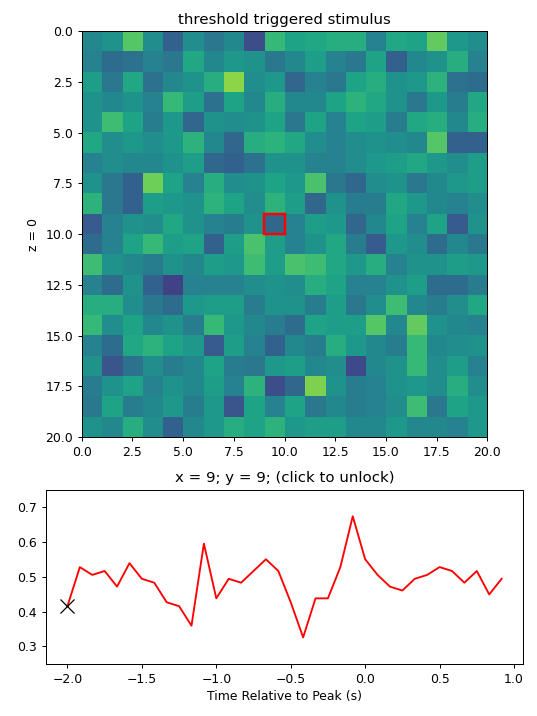

In [10]:
lead_stack_plot = StackExplorer(    
    window_stack,
    zaxis=window_xaxis,
    delta=1,
    roi_sz=1,
    vmin=.25,
    vmax=.75,
    cmap="viridis",
#     cmap="cividis",
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

### Rough "receptive field" map via response vs baseline subtraction
Set baseline and response windows in terms of `window_xaxis`. This is not actually the method used by Aki, rather in his lab, they just use the temporal signal of the spatial RF, unmodified other than averaging / filtering.

<IPython.core.display.Javascript object>


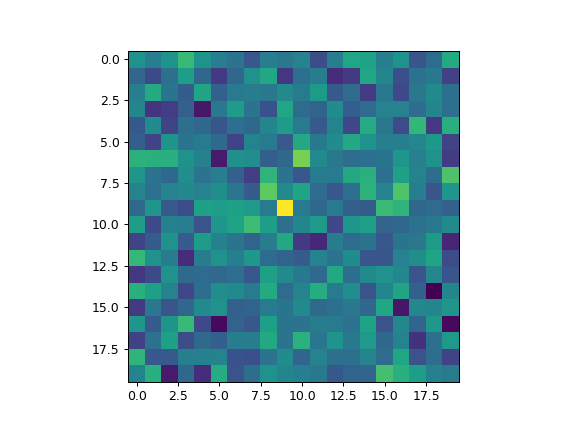

In [11]:
# bsln_mean_t0 = -2
bsln_mean_t0 = -0.5
bsln_mean_t1 = -.2
resp_mean_t0 = -.2
resp_mean_t1 = 0

# bsln_mean_t0 = -.5
# bsln_mean_t1 = -.3
# resp_mean_t0 = -.2
# resp_mean_t1 = 0

bsln_mean_mask = (bsln_mean_t0 <= window_xaxis) * (window_xaxis <= bsln_mean_t1)
bsln_mean = np.mean(window_stack[bsln_mean_mask], axis=0)
resp_mean_mask = (resp_mean_t0 <= window_xaxis) * (window_xaxis <= resp_mean_t1)
resp_mean = np.mean(window_stack[resp_mean_mask], axis=0)
sub_mean = resp_mean - bsln_mean

sub_field_fig, sub_field_ax = plt.subplots(1)
sub_field_ax.imshow(
    sub_mean,
#     vmin=-.2,
#     vmax=.2,
#     cmap="gray",
)

### Variability spatial map

Variance of time immediately before event vs baseline time before. 

<IPython.core.display.Javascript object>


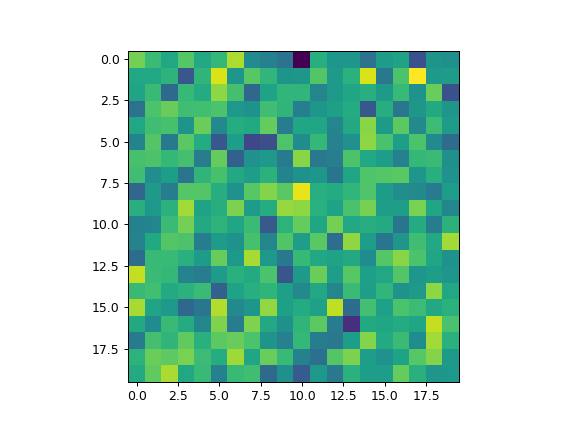

In [12]:
bsln_var_t0 = -2
bsln_var_t1 = -1
resp_var_t0 = -1
resp_var_t1 = 0

bsln_var_mask = (bsln_var_t0 <= window_xaxis) * (window_xaxis <= bsln_var_t1)
bsln_var = np.var(window_stack[bsln_var_mask], axis=0)
resp_var_mask = (resp_var_t0 <= window_xaxis) * (window_xaxis <= resp_var_t1)
resp_var = np.var(window_stack[resp_var_mask], axis=0)
sub_var = resp_var - bsln_var

var_field_fig, var_field_ax = plt.subplots(1)
var_field_ax.imshow(
    sub_var,
    vmin=None,
    vmax=None, 
#     cmap="gray",
)

Peak times acquired with `signal.find_peaks` are in agreement with examples provided by Aki, but are consistently later by one time step. Thus, we can expect to find the same triggered stimuli from the same glusnfr recordings.

In [13]:
peak_idxs, peak_proms = signal.find_peaks(
    df,
    prominence=.2,
    width=2,
    rel_height=.5,
    distance=2,
)
peak_times = df_xaxis[peak_idxs]

diffs = peak_times - pks
print("timestep (dt) of df recording:", df_dt)
print("average difference:", np.mean(diffs))
print("average absolute difference:", np.mean(np.abs(diffs)))
print("diffs:")
print(diffs)

timestep (dt) of df recording: 0.10526315789473983
average difference: -0.1052631578947647
average absolute difference: 0.1052631578947647
diffs:
[-0.10526316 -0.10526316 -0.10526316 -0.10526316 -0.10526316 -0.10526316
 -0.10526316 -0.10526316 -0.10526316 -0.10526316 -0.10526316 -0.10526316
 -0.10526316 -0.10526316 -0.10526316 -0.10526316]


In [14]:
print("noise shape:", noise.shape)
print("rec shape:", df.shape)
print("df dt =", df_dt)
print("noise dt =", noise_dt)
print(nearest_index(noise_xaxis, np.min(df_xaxis)))
print(nearest_index(noise_xaxis, np.max(df_xaxis)))

noise shape: (3200, 20, 20)
rec shape: (598,)
df dt = 0.10526315789473983
noise dt = 0.08333333333333333
601
1355


<IPython.core.display.Javascript object>


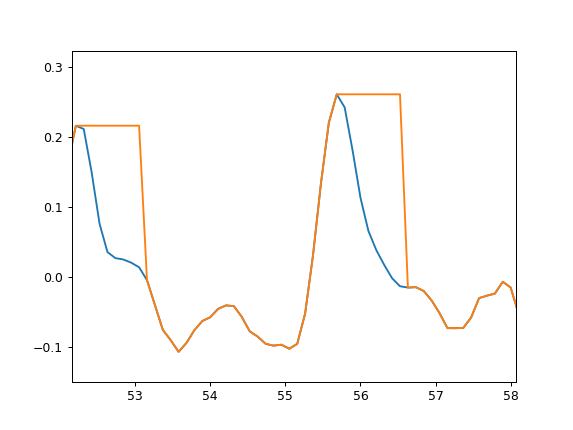

In [15]:
smear_t = 1.
smeared_df = np.copy(df)

for i in peak_idxs:
    smeared_df[i:i+int(smear_t / df_dt)] = smeared_df[i]
    
fff, aaa = plt.subplots(1)
aaa.plot(df_xaxis, df)
aaa.plot(df_xaxis, smeared_df)

In [19]:
noise_rec_start_idx = nearest_index(noise_xaxis, np.min(df_xaxis))
noise_rec_end_idx =nearest_index(noise_xaxis, np.max(df_xaxis))

new_len = int(df_dt / noise_dt * len(df))
upsample_df = map_axis(lambda a: signal.resample(a, new_len), df)
# upsample_df = map_axis(lambda a: signal.resample(a, new_len), smeared_df)
crop_noise = noise[noise_rec_start_idx - 300:noise_rec_end_idx + 300]
crop_len = crop_noise.shape[0]

mode = "valid"
if mode == "valid":
    corr_len = max(new_len, crop_len) - min(new_len, crop_len) + 1
elif mode == "same":
    corr_len = max(new_len, crop_len)
else:
    corr_len = new_len + crop_len - 1  # full

trial = []
for c in range(noise.shape[1]):
    for r in range(noise.shape[2]):
        nz = crop_noise[:, c, r]
        trial.append(np.correlate(upsample_df, nz, mode=mode))
#         trial.append(np.convolve(upsample_df, np.flip(nz), mode=mode))
#         trial.append(np.convolve(upsample_df, nz, mode=mode))

cross = np.stack(trial, axis=1).reshape(
#     corr_len, noise.shape[1], noise.shape[2]).transpose(0, 2, 1) 
    corr_len, noise.shape[1], noise.shape[2])

<IPython.core.display.Javascript object>


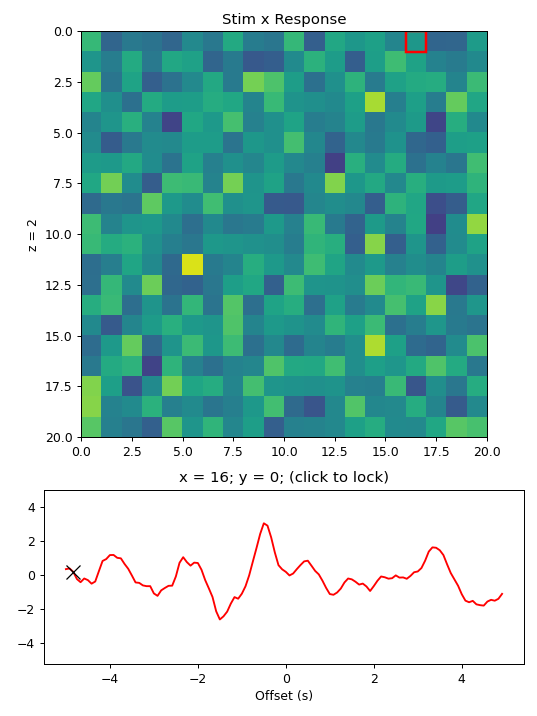

In [20]:
mid_cross_idx = corr_len // 2
crop_cross = cross[mid_cross_idx-60:mid_cross_idx+60]
crop_cross_xaxis = (np.arange(crop_cross.shape[0]) - crop_cross.shape[0] / 2) * noise_dt

cross_plot = StackExplorer(    
    crop_cross,
    zaxis=crop_cross_xaxis,
    delta=1,
    roi_sz=1,
    cmap="viridis",
    figsize=(6, 8)
)
cross_plot.stack_ax.set_title("Stim x Response")
cross_plot.beam_ax.set_xlabel("Offset (s)")
cross_plot.fig.tight_layout()

<IPython.core.display.Javascript object>


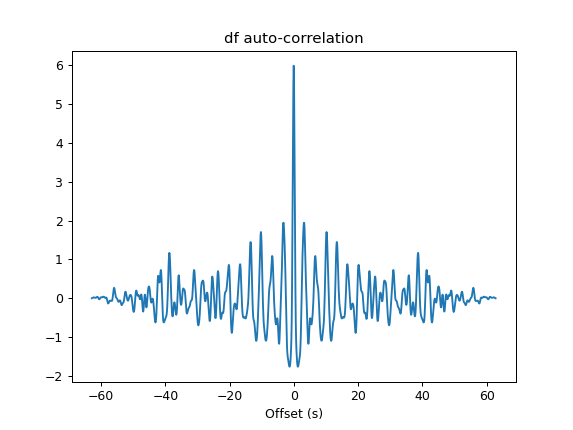

Text(0.5, 0, 'Offset (s)')

In [25]:
df_autocorr = np.correlate(df, df, mode="full")

auto_fig, auto_ax = plt.subplots(1)
auto_ax.plot((np.arange(len(df_autocorr)) - len(df_autocorr) / 2) * df_dt, df_autocorr)
auto_ax.set_title("df auto-correlation")
auto_ax.set_xlabel("Offset (s)")